In [1]:
# First we import the required libraries

import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import io

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 
K.clear_session()

# Check tensorflow version
if float(tf.__version__[0]) < 2.0:
  print('Updating tensorflow')
  !pip install tensorflow==2.0
else:
  print('Correct version of Tensorflow installed.')

Correct version of Tensorflow installed.


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/GNR_project

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1Jy3ikjmRyrUXuihE1Z7xTzK9qnYaJsRw/GNR_project


In [3]:
data = pd.read_csv('dataset_processed.csv')
data.head()

,Unnamed: 0,title,text,label
0,0,you can smell hillaryís fear,daniel greenfield shillman journalism fellow f...,1
1,1,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,1
2,2,kerry go paris gesture sympathy,u s secretary state john f kerry said monday s...,0
3,3,bernie supporters twitter erupt anger dnc we t...,kaydee king november the lesson tonight dem l...,1
4,4,the battle new york why this primary matters,it primary day new york front runners hillary ...,0


In [6]:
data.fillna('')
data.count()

Unnamed: 0    32289
title         31607
text          32289
label         32289
dtype: int64

In [7]:
data.drop(['Unnamed: 0'], axis=1)

,title,text,label
0,you can smell hillaryís fear,daniel greenfield shillman journalism fellow f...,1
1,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,1
2,kerry go paris gesture sympathy,u s secretary state john f kerry said monday s...,0
3,bernie supporters twitter erupt anger dnc we t...,kaydee king november the lesson tonight dem l...,1
4,the battle new york why this primary matters,it primary day new york front runners hillary ...,0
...,...,...,...
32284,the bangladeshi traffic jam that never ends th...,of dysfunctions plague worlds megacities none ...,0
32285,john kasich signs one abortion bill ohio vetoe...,washington gov john kasich ohio tuesday signed...,1
32286,california today what exactly is your sushi th...,good morning want get california today email h...,0
32287,us marines to be deployed to russian border i...,previous next us marines to be deployed to ru...,1


In [8]:
# Tokenize text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])
word_index = tokenizer.word_index
vocab_size=len(word_index)
print(vocab_size)

# Padding data

sequences = tokenizer.texts_to_sequences(data['text'])
padded = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

177484


In [0]:
split = 0.35
split_n = int(round(len(padded)*(1-split),0))
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(padded, data['label'], test_size=0.35, random_state=42, stratify=data['label'])
#train_data = padded[:split_n]
#train_labels = data['label'].values[:split_n]
#test_data = padded[split_n:]
#test_labels = data['label'].values[split_n:]

In [10]:
# Import tensor representations for words

embeddings_index = {};
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

100


In [0]:
# Build the architecture of the model
     
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.4),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [23]:
#learning rate decay
#decayed_learning_rate(step) = initial_learning_rate * decay_rate ^ (step / decay_steps)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=700,
    decay_rate=0.9)

optimizer_ = tf.keras.optimizers.Adam(
    learning_rate= lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

model.compile(loss='binary_crossentropy',optimizer=optimizer_ ,metrics=['accuracy'])
model.summary()

history = model.fit(train_data, train_labels, epochs=100, batch_size=64, validation_data=(test_data, test_labels))

print("Training Complete")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         17748500  
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, None, 20)          6800      
_________________________________________________________________
lstm_13 (LSTM)               (None, None, 20)          3280      
_________________________________________________________________
lstm_14 (LSTM)               (None, 20)               

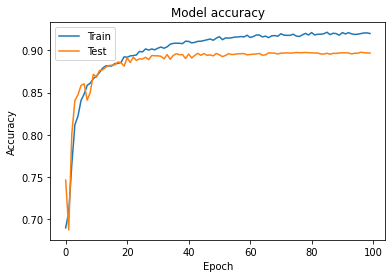

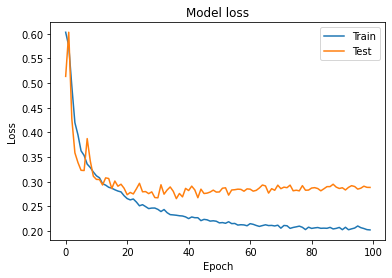

In [24]:
# Visualize the results:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()